### Business Understanding

Pada proyek akhir ini saya akan mencari sebuah topik yang menyangkut calon presiden 2024 untuk dianalisis guna melihat bagaimana sentimen yang terjadi di media sosial terhadap setiap calon presiden yang tersedia

### Data Understanding

In [245]:
#module yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, tweepy, requests, re, string
import seaborn as sns
import datetime
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory as SF
from urllib.request import urlopen
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Data Collection

In [177]:
#mendapatkan akses twitter developer
with open("token.json")as f:
    tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [178]:
#mengambil 300 data dari twitter
query = "calon presiden 2024 -is:retweet lang:id"
start_time = '2023-01-18T00:00:00Z'
end_time = '2023-01-21T00:00:00Z'
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)
response = tweepy.Paginator(api.search_recent_tweets,
                            query = query,
                            max_results=100,
                            start_time=start_time,
                            end_time=end_time,
                            tweet_fields=['created_at']
                          ).flatten(limit=300)

In [179]:
#menyimpan data ke dalam list
tweets = []
dates = []
for data in response:
    tweets.append(data.text.strip())
    dates.append(data.created_at)

In [180]:
#membuat dataframe dari list sebelumny
df = pd.DataFrame({'tanggal':dates,'tweet':tweets})
df.head()

,tanggal,tweet
0,2023-01-20 23:09:45+00:00,@AnakLolina2 Smoga kedepannya GP ada yg mengus...
1,2023-01-20 18:49:07+00:00,"Muzani menegaskan, keputusan calon presiden da..."
2,2023-01-20 18:42:30+00:00,"Sekjen Muzani menegaskan, keputusan calon pres..."
3,2023-01-20 18:35:54+00:00,"Muzani menegaskan, keputusan calon presiden da..."
4,2023-01-20 18:35:51+00:00,@CNNIndonesia Bukan anggaran covid itu dari pe...


In [181]:
df['tanggal'] = pd.to_datetime(df['tanggal'],utc=True)
df['tanggal'] = df['tanggal'].dt.date

In [182]:
df.head()

,tanggal,tweet
0,2023-01-20,@AnakLolina2 Smoga kedepannya GP ada yg mengus...
1,2023-01-20,"Muzani menegaskan, keputusan calon presiden da..."
2,2023-01-20,"Sekjen Muzani menegaskan, keputusan calon pres..."
3,2023-01-20,"Muzani menegaskan, keputusan calon presiden da..."
4,2023-01-20,@CNNIndonesia Bukan anggaran covid itu dari pe...


In [183]:
#mengambil 10 data dari situs harianterbit.com
alamat = "https://www.harianterbit.com/tag/Pilpres-2024"
html = urlopen(alamat)
data = BeautifulSoup(html, 'html.parser')

In [184]:
table = data.findAll("div", {"class":"latest__wrap"})[0]
rows = table.findAll("div", {"class":"latest__right"})

In [185]:
titles = []
dates2 = []
for row in rows:
    for title in row.findAll("a", {"class":"latest__link"}):
        titles.append(title.get_text())
    for date in row.findAll("date", {"class":"latest__date"}):
        dates2.append(date.get_text())

In [186]:
new_date = []
for i in dates2:
    new_date.append(datetime.datetime(int(i.split()[3]), 1, int(i.split()[1])))

In [187]:
#menyimpan data baru ke dataframe sementara
df_temp = pd.DataFrame({'tanggal':new_date,'tweet':titles})
df_temp

,tanggal,tweet
0,2023-01-21,"Rangkul Milenial, Sahabat Ganjar Gelar Kegiata..."
1,2023-01-17,Duet Prabowo-Puan Dinilai Sulit Terwujud di Pi...
2,2023-01-14,Sandiaga Kepada Prabowo: Tunduk dan Loyal ke G...
3,2023-01-13,"Prabowo Ditinggal Pemilih Muslim, Beralih ke A..."
4,2023-01-12,Pemilih Prabowo Pindah ke Anies Baswedan!
5,2023-01-05,Ramalan Hard Gumay tentang Presiden 2024: Suku...
6,2023-01-03,Ketum PBB Yusril sebut Calon Presiden yang Ide...
7,2023-01-02,Kembali pada Sistem Proporsional Tertutup Dise...
8,2023-01-01,Ramalan Capres 2024: Dari yang Pro Kontra Hing...
9,2023-01-01,"Ramalan Pilpres 2024: Ada Lima Bakal Capres, H..."


In [188]:
df_temp['tanggal'] = df_temp['tanggal'].dt.date

In [189]:
#menyatukan dataframe
df = pd.concat([df,df_temp],ignore_index=True)
df.shape

(310, 2)

In [190]:
#simpan menjadi file .csv
df.to_csv('data_mentah_yosabad.csv')

#### Data Preprocessing

In [193]:
data = pd.read_csv('data_mentah_yosabad.csv',index_col=0)
data.head()

,tanggal,tweet
0,2023-01-20,@AnakLolina2 Smoga kedepannya GP ada yg mengus...
1,2023-01-20,"Muzani menegaskan, keputusan calon presiden da..."
2,2023-01-20,"Sekjen Muzani menegaskan, keputusan calon pres..."
3,2023-01-20,"Muzani menegaskan, keputusan calon presiden da..."
4,2023-01-20,@CNNIndonesia Bukan anggaran covid itu dari pe...


In [194]:
#melihat slang pada setiap kalimat
def slangs(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    twt = [word for tweet in data for word in tweet]
    fqdist = FreqDist(twt)
    most_common_word = fqdist.most_common(15)
    return fqdist, most_common_word

print('Cek slang di dataset:')
slangs(data['tweet'])[1]

Cek slang di dataset:


[('#', 401),
 ('presiden', 308),
 ('calon', 287),
 ('2024', 281),
 ('Prabowo', 270),
 ('.', 256),
 (',', 245),
 ('di', 213),
 (':', 208),
 ('https', 201),
 ('@', 168),
 ('Subianto', 143),
 ('Pilpres', 119),
 ('(', 113),
 (')', 113)]

In [195]:
#mengubah format data dan menghapus slang
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("","",string.punctuation))
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    return data

def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian")
    sw_indonesia.extend(['https','di'])
    data  = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data

In [196]:
for index in range (len(data["tweet"])):
    data["tweet"].iloc[index] = case_folding(data["tweet"].iloc[index])
    data["tweet"].iloc[index] = word_tokenize(data["tweet"].iloc[index])
    data["tweet"].iloc[index] = stopword_cleaner(data["tweet"].iloc[index])

In [197]:
data.head()

,tanggal,tweet
0,2023-01-20,smoga kedepannya gp yg mengusung jdi calon pre...
1,2023-01-20,muzani keputusan calon presiden wakil presiden...
2,2023-01-20,sekjen muzani keputusan calon presiden wakil p...
3,2023-01-20,muzani keputusan calon presiden wakil presiden...
4,2023-01-20,anggaran covid pengsung calon presiden mu anie...


#### Data Analysis

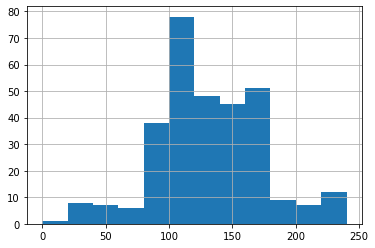

In [207]:
#melihat distribusi frekuensi karakter per kalimat
char_freq = np.arange(0, 250, 20)
data['tweet'].str.len().hist(bins=char_freq)
plt.show()

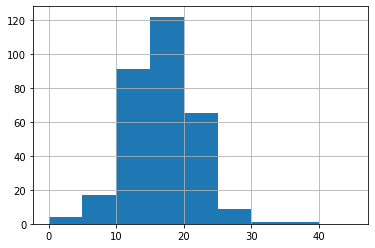

In [209]:
#melihat distribusi panjang kata per kalimat
word_len = np.arange(0, 50, 5)
data['tweet'].str.split().map(lambda x: len(x)).hist(bins=word_len)
plt.show()

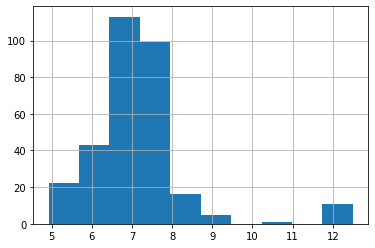

In [210]:
#melihat distribusi panjang rata-rata kata per kalimat
data['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

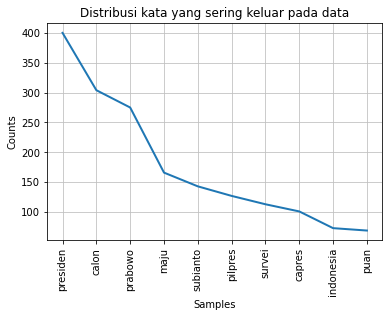

In [212]:
#melihat distribusi kata yang sering keluar
slangs(data['tweet'])[0].plot(10,cumulative=False,title='Distribusi kata yang sering keluar pada data')
plt.show()

#### Data Processing (tidak menggunakan machine learning)

In [236]:
#membuka file berisi kata positif dan negatif
with open("./kata_positif.txt","r") as positif_file :
    positive_words = list(set(positif_file.readlines()))
with open("./kata_negatif.txt","r") as negative_file :
    negative_words = list(set(negative_file.readlines()))

In [237]:
#mengecek setiap kata apakah termasuk kata positif atau negatif
hasil = []
for tweet in data['tweet']:
    tweet_clean = tweet.strip().split()
    good_count = 0
    bad_count = 0
    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
            good_count += count
    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
            bad_count += count
    hasil.append(good_count - bad_count)

In [238]:
#menambah kolom baru berupa sentimen
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
data["sentiment"] = sentiments

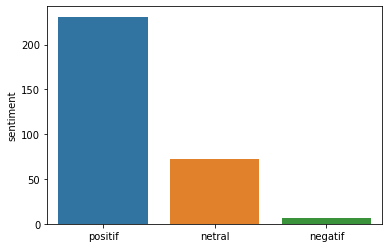

In [239]:
#visualisasi sentimen
n = data['sentiment'].value_counts()
sns.barplot(x=n.index, y=n)
plt.show()

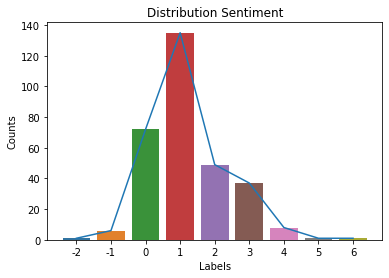

In [242]:
#melihat distribusi sentimen dari skor yang dihasilkan
labels, counts = np.unique(hasil, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())
sns.barplot(x = list(labels), 
            y = list(counts))
sns.lineplot(x = ax.get_xticks(), 
            y = list(counts))
plt.title('Distribution Sentiment')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

In [241]:
#melihat bigram sentimen dengan nilai terbanyak yaitu sentimen positif
pos = [word for tweet in data[data['sentiment']=='positif']['tweet'] for word in tweet.split()]
result = pd.Series(nltk.ngrams(pos, 2)).value_counts()[:20]
print(result)

(calon, presiden)           213
(prabowo, subianto)         117
(maju, calon)                72
(prabowo, indonesia)         65
(indonesia, maju)            65
(mending, prabowo)           60
(elektabilitas, prabowo)     51
(survei, calon)              51
(presiden, capres)           48
(subianto, maju)             44
(teratas, survei)            44
(lembaga, survei)            42
(survei, nasional)           42
(ridwan, kamil)              37
(joko, widodo)               36
(presiden, lembaga)          36
(presiden, joko)             35
(urutan, teratas)            33
(partai, gerindra)           31
(pilpres, bersamajuara)      30
dtype: int64


### Reporting

Berdasarkan analisis di atas, didapatkan beberapa informasi yang dapat dirangkum menjadi poin-poin berikut:
- Dataset memiliki persebaran 10 hingga 20 kata per kalimat yang mana setiap kalimat memiliki 6 hingga 8 kata
- Setiap kalimat terdiri dari 100 hingga 120 karakter
- Tiga kata yang paling sering keluar pada data ini adalah "presiden", "calon", dan "prabowo"
- Sentimen yang dimiliki oleh dataset ini adalah sentimen positif dengan jumlah lebih dari 200 baris data
- Tiga bigram (2 kata) yang sering dibicarakan pada data yang memiliki sentimen positif adalah "calon presiden", "prabowo subianto", dan "maju calon"